In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score, mean_squared_error, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [9]:
df = pd.read_csv('mid_cap_all_sectors_ret.csv')
df['date'] = pd.to_datetime(df['date'])

## **Only Log Return Feature**

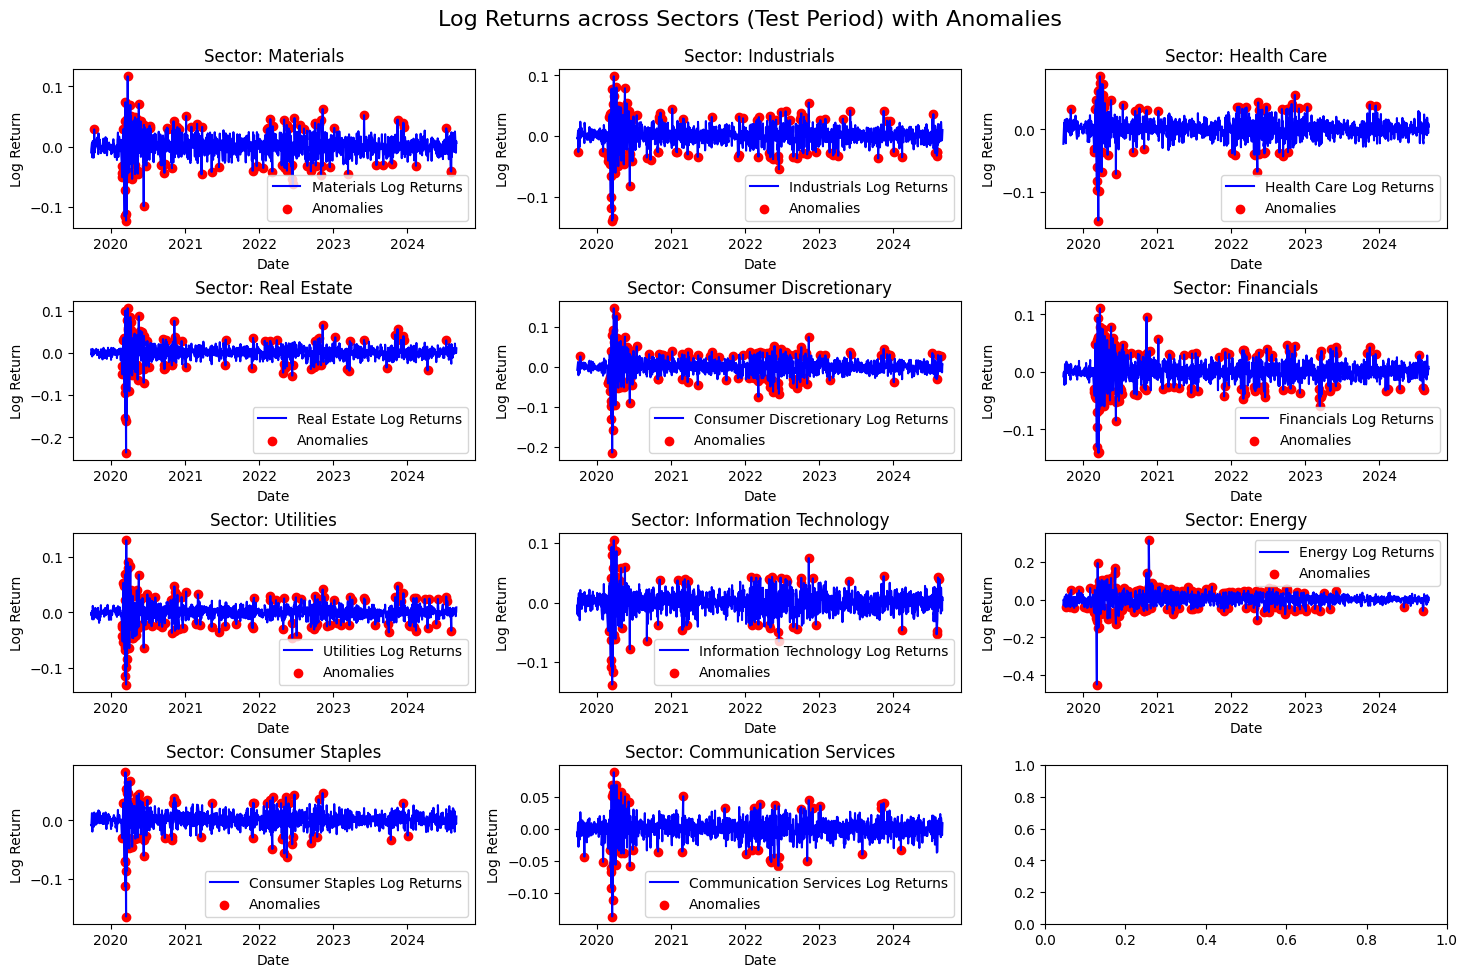

,n_estimators,max_samples,contamination,silhouette_score,mse,anomaly_percentage
Materials,95.0,0.5,0.03,0.663277,0.017691,4.754230
Industrials,85.0,0.4,0.03,0.682734,0.020123,4.512490
Health Care,100.0,0.4,0.03,0.738485,0.018727,2.014504
Real Estate,95.0,0.7,0.03,0.772613,0.023942,2.739726
Consumer Discretionary,85.0,0.7,0.03,0.686187,0.015528,4.673650
Financials,115.0,0.4,0.03,0.677878,0.021127,5.237712
Utilities,115.0,0.4,0.03,0.687127,0.017585,6.124093
Information Technology,85.0,0.4,0.03,0.745715,0.019848,1.692184
Energy,105.0,0.5,0.03,0.634997,0.015473,7.493956
Consumer Staples,105.0,0.4,0.03,0.746916,0.016835,2.336825


In [13]:
sectors = df.columns[1:]

# 80%/20%
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:].copy()

anomalies_dict = {}
best_params = {}
metrics = {}

# fine tuning
param_grid = {
    'n_estimators': [85, 95, 100, 105, 115],
    'max_samples': [0.4, 0.5, 0.6, 0.7],
    'contamination': [0.03, 0.04, 0.045, 0.05, 0.055, 0.06]
}

# Plot
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Log Returns across Sectors (Test Period) with Anomalies', fontsize=16)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.92)

# Loop through each sector and apply Isolation Forest
for i, sector in enumerate(sectors):
    best_silhouette = -1
    best_config = None
    best_model = None

    # Loop over parameter grid to find the best model
    for n_estimators in param_grid['n_estimators']:
        for max_samples in param_grid['max_samples']:
            for contamination in param_grid['contamination']:
                # Initialize Isolation Forest with current parameters
                model = IsolationForest(n_estimators=n_estimators, max_samples=max_samples,
                                        contamination=contamination, random_state=42)

                X_train = train_df[[sector]].values
                model.fit(X_train)

                # Predict anomalies on the test data
                X_test = test_df[[sector]].values
                test_df[f'{sector}_anomaly'] = model.predict(X_test)
                test_df[f'{sector}_anomaly'] = test_df[f'{sector}_anomaly'].apply(lambda x: 0 if x == 1 else -1)

                # Metrics
                silhouette = silhouette_score(X_test, test_df[f'{sector}_anomaly'])
                mse = mean_squared_error(test_df[sector], model.decision_function(X_test))
                anomaly_percentage = (test_df[f'{sector}_anomaly'] == -1).mean() * 100

                # Check if this configuration is better
                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_config = {
                        'n_estimators': n_estimators,
                        'max_samples': max_samples,
                        'contamination': contamination,
                        'silhouette_score': silhouette,
                        'mse': mse,
                        'anomaly_percentage': anomaly_percentage
                    }
                    best_model = model

    best_params[sector] = best_config
    metrics[sector] = best_config

    # Plot the best model's results
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(test_df['date'], test_df[sector], label=f'{sector} Log Returns', color='blue')

    # Identify anomaly points in the test data and plot them
    anomaly_dates = test_df[test_df[f'{sector}_anomaly'] == -1]['date']
    anomaly_values = test_df[test_df[f'{sector}_anomaly'] == -1][sector]
    ax.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
    ax.set_title(f'Sector: {sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.show()
metrics_df = pd.DataFrame(metrics).T
metrics_df

In [14]:
# save anomaly
anomaly_df = test_df[['date']].copy()
for sector in sectors:
    anomaly_df[sector] = test_df[f'{sector}_anomaly'].apply(lambda x: 1 if x == -1 else 0)
anomaly_df

,date,Materials,Industrials,Health Care,Real Estate,Consumer Discretionary,Financials,Utilities,Information Technology,Energy,Consumer Staples,Communication Services
4963,2019-09-26,0,0,0,0,0,0,0,0,0,0,0
4964,2019-09-27,0,0,0,0,0,0,0,0,0,0,0
4965,2019-09-30,0,0,0,0,0,0,0,0,0,0,0
4966,2019-10-01,0,1,0,0,0,0,0,0,0,0,0
4967,2019-10-02,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6199,2024-08-26,0,0,0,0,0,0,0,0,0,0,0
6200,2024-08-27,0,0,0,0,0,0,0,0,0,0,0
6201,2024-08-28,0,0,0,0,0,0,0,0,0,0,0
6202,2024-08-29,0,0,0,0,0,0,0,0,0,0,0


In [15]:
anomaly_df.to_csv('isolation_anomalies_with_financialcrisis.csv', index=False)

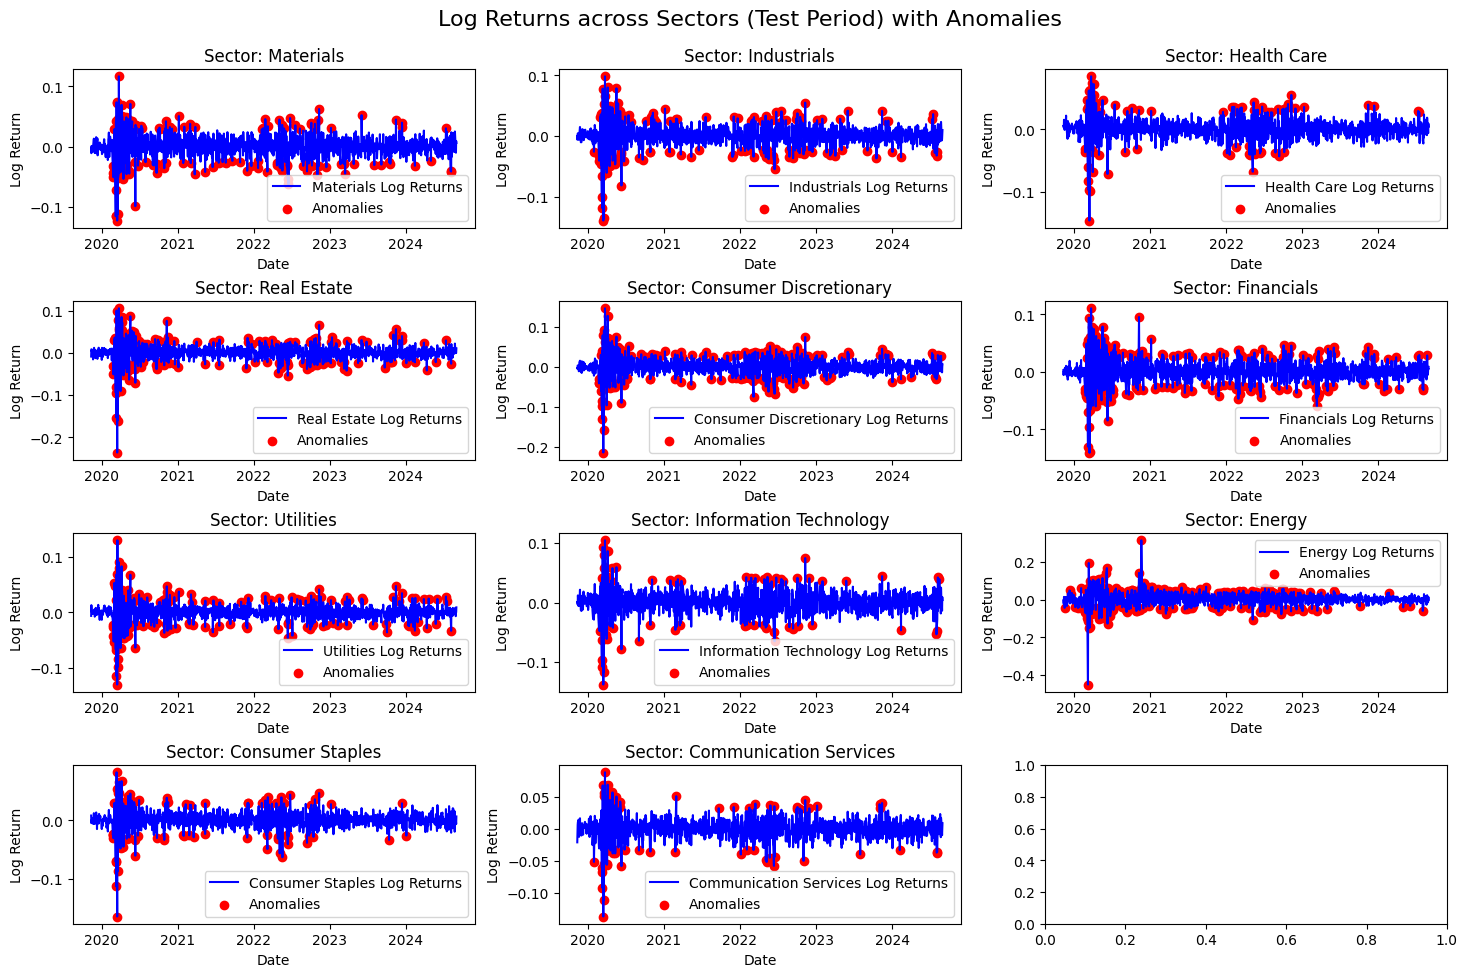

,n_estimators,max_samples,contamination,silhouette_score,mse,anomaly_percentage
Materials,85.0,0.5,0.03,0.626827,0.016147,6.788079
Industrials,105.0,0.4,0.03,0.639734,0.016984,6.953642
Health Care,100.0,0.4,0.03,0.710833,0.018532,2.897351
Real Estate,85.0,0.4,0.03,0.693130,0.021407,5.794702
Consumer Discretionary,115.0,0.6,0.03,0.636725,0.016204,7.036424
Financials,100.0,0.4,0.03,0.621689,0.016956,8.609272
Utilities,95.0,0.6,0.03,0.648770,0.014454,8.443709
Information Technology,85.0,0.4,0.03,0.743858,0.019619,1.738411
Energy,85.0,0.5,0.03,0.596870,0.013862,10.016556
Consumer Staples,100.0,0.4,0.03,0.722306,0.015346,2.980132


In [16]:
# exclude financial 2008-08-01 to 2009-04-01
df = pd.read_csv('mid_cap_all_sectors_ret.csv')
df['date'] = pd.to_datetime(df['date'])
sectors = df.columns[1:]

# exclude data
excluded_period_start = '2008-08-01'
excluded_period_end = '2009-04-01'
filtered_df = df[(df['date'] < excluded_period_start) | (df['date'] > excluded_period_end)]

# 80%/20%
split_point = int(len(filtered_df) * 0.8)
train_df = filtered_df.iloc[:split_point]
test_df = filtered_df.iloc[split_point:].copy()

anomalies_dict = {}
best_params = {}
metrics = {}

# fine tuning
param_grid = {
    'n_estimators': [85, 95, 100, 105, 115],
    'max_samples': [0.4, 0.5, 0.6, 0.7],
    'contamination': [0.03, 0.04, 0.045, 0.05, 0.055, 0.06]
}

# Plot
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Log Returns across Sectors (Test Period) with Anomalies', fontsize=16)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.92)

# Loop through each sector and apply Isolation Forest
for i, sector in enumerate(sectors):
    best_silhouette = -1
    best_config = None
    best_model = None

    # Loop over parameter grid to find the best model
    for n_estimators in param_grid['n_estimators']:
        for max_samples in param_grid['max_samples']:
            for contamination in param_grid['contamination']:
                # Initialize Isolation Forest with current parameters
                model = IsolationForest(n_estimators=n_estimators, max_samples=max_samples,
                                        contamination=contamination, random_state=42)

                X_train = train_df[[sector]].values
                model.fit(X_train)

                # Predict anomalies on the test data
                X_test = test_df[[sector]].values
                test_df[f'{sector}_anomaly'] = model.predict(X_test)
                test_df[f'{sector}_anomaly'] = test_df[f'{sector}_anomaly'].apply(lambda x: 0 if x == 1 else -1)

                # Metrics
                silhouette = silhouette_score(X_test, test_df[f'{sector}_anomaly'])
                mse = mean_squared_error(test_df[sector], model.decision_function(X_test))
                anomaly_percentage = (test_df[f'{sector}_anomaly'] == -1).mean() * 100

                # Check if this configuration is better
                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_config = {
                        'n_estimators': n_estimators,
                        'max_samples': max_samples,
                        'contamination': contamination,
                        'silhouette_score': silhouette,
                        'mse': mse,
                        'anomaly_percentage': anomaly_percentage
                    }
                    best_model = model

    best_params[sector] = best_config
    metrics[sector] = best_config

    # Plot the best model's results
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(test_df['date'], test_df[sector], label=f'{sector} Log Returns', color='blue')

    # Identify anomaly points in the test data and plot them
    anomaly_dates = test_df[test_df[f'{sector}_anomaly'] == -1]['date']
    anomaly_values = test_df[test_df[f'{sector}_anomaly'] == -1][sector]
    ax.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
    ax.set_title(f'Sector: {sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.show()

metrics_df = pd.DataFrame(metrics).T
metrics_df

In [18]:
# save anomaly
anomaly_df1 = test_df[['date']].copy()
for sector in sectors:
    anomaly_df1[sector] = test_df[f'{sector}_anomaly'].apply(lambda x: 1 if x == -1 else 0)
anomaly_df1.to_csv('isolation_anomalies_without_financialcrisis.csv', index=False)

## **Log Return & Rolling Vol**

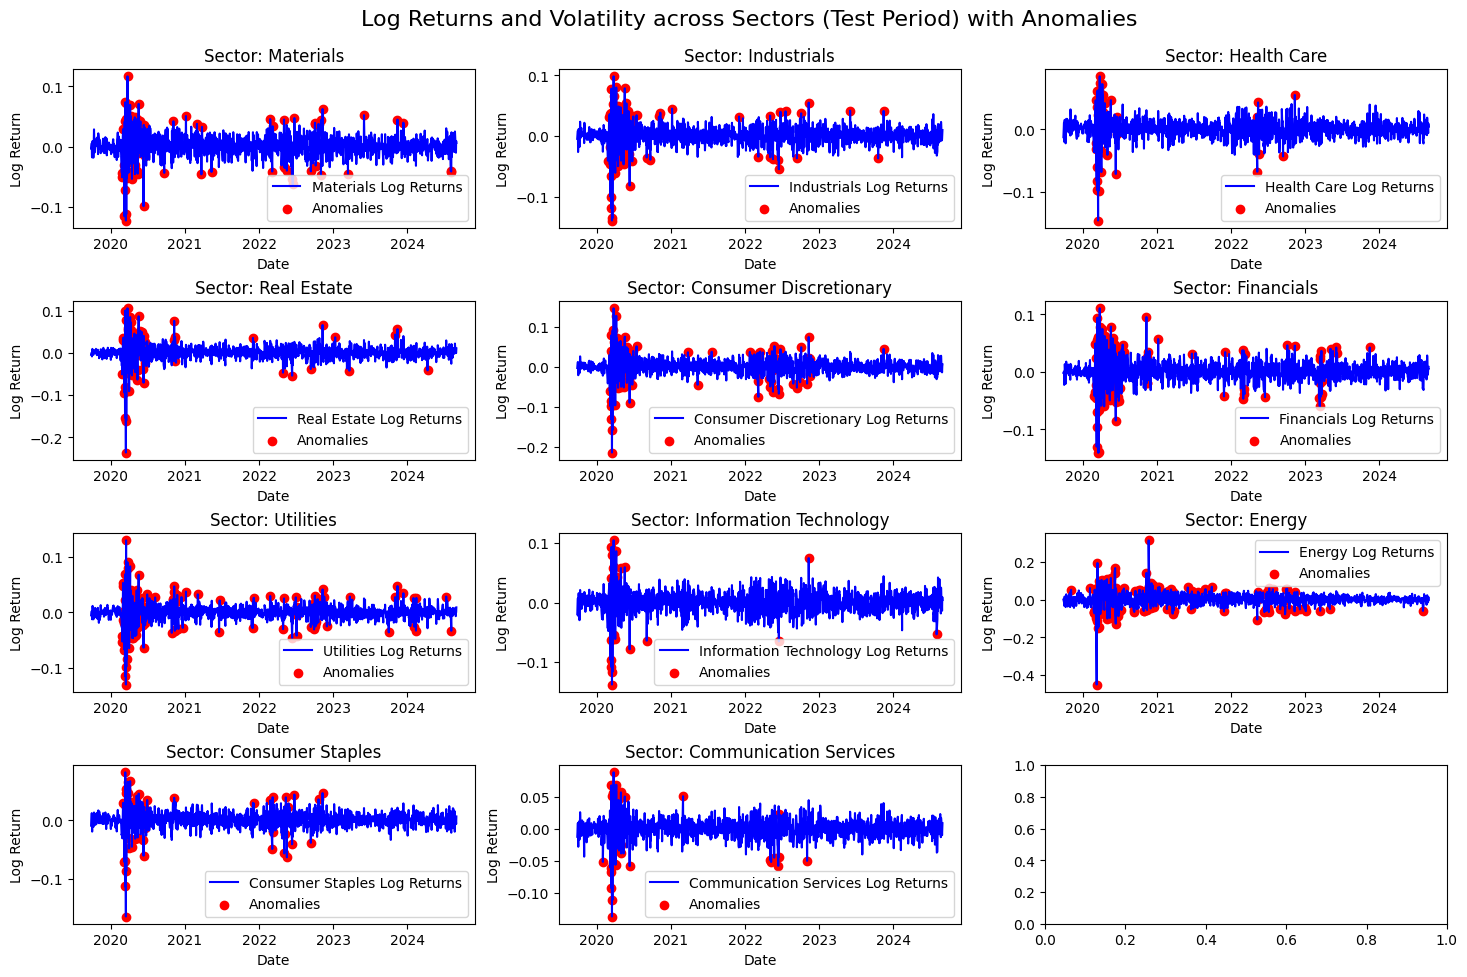

,silhouette_score,mse,anomaly_percentage
Materials,0.619371,0.024397,6.612903
Industrials,0.631485,0.025209,7.016129
Health Care,0.694686,0.025237,3.306452
Real Estate,0.717531,0.031645,5.000000
Consumer Discretionary,0.619575,0.025419,7.741935
Financials,0.620961,0.027915,8.467742
Utilities,0.624868,0.023449,9.596774
Information Technology,0.725573,0.027001,2.177419
Energy,0.559081,0.020216,11.935484
Consumer Staples,0.679176,0.024236,4.274194


In [ ]:
# 5-day rolling volatility for each sector as an additional feature
for sector in sectors:
    df[f'{sector}_vol_5'] = df[sector].rolling(window=5).std()

df.dropna(inplace=True)

# 80%/20%
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:].copy()

anomalies_dict = {}
metrics = {}

# Plot
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Log Returns and Volatility across Sectors (Test Period) with Anomalies', fontsize=16)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.92)

# Loop through each sector and apply Isolation Forest with both log returns and volatility as features
for i, sector in enumerate(sectors):
    # Prepare the training and testing data (log returns and 5-day rolling volatility)
    X_train = train_df[[sector, f'{sector}_vol_5']].values
    X_test = test_df[[sector, f'{sector}_vol_5']].values

    # Initialize and train the Isolation Forest model on training data
    model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)
    model.fit(X_train)

    # Predict anomalies in the test set
    test_df[f'{sector}_anomaly'] = model.predict(X_test)

    # Convert 1 (normal) to 0 (normal), so -1 represents anomalies and 0 represents normal points
    test_df[f'{sector}_anomaly'] = test_df[f'{sector}_anomaly'].apply(lambda x: 0 if x == 1 else -1)

    silhouette = silhouette_score(X_test, test_df[f'{sector}_anomaly'])
    mse = mean_squared_error(test_df[sector], model.decision_function(X_test))
    metrics[sector] = {
        'silhouette_score': silhouette,
        'mse': mse,
        'anomaly_percentage': (test_df[f'{sector}_anomaly'] == -1).mean() * 100
    }

    # Plot
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(test_df['date'], test_df[sector], label=f'{sector} Log Returns', color='blue')

    # Identify anomaly points in the test data and plot them
    anomaly_dates = test_df[test_df[f'{sector}_anomaly'] == -1]['date']
    anomaly_values = test_df[test_df[f'{sector}_anomaly'] == -1][sector]
    ax.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
    ax.set_title(f'Sector: {sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.show()
metrics_df = pd.DataFrame(metrics).T
metrics_df

## **Log Return & SMA & Rolling Vol**

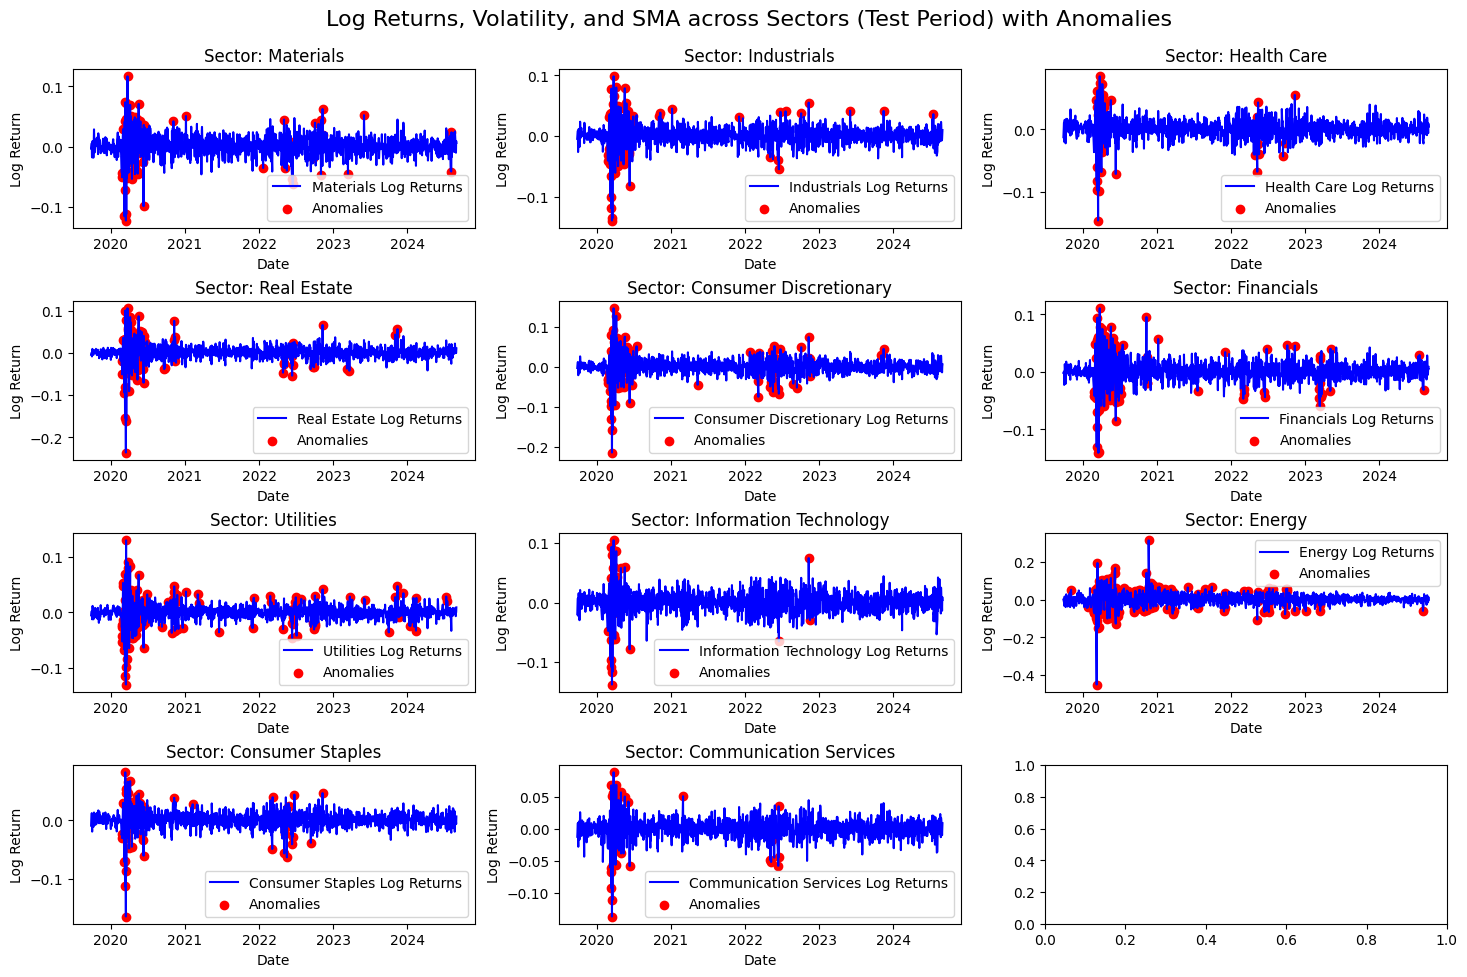

,silhouette_score,mse,anomaly_percentage
Materials,0.603130,0.025319,5.725806
Industrials,0.615562,0.024647,6.693548
Health Care,0.680138,0.026403,3.306452
Real Estate,0.668305,0.030400,6.290323
Consumer Discretionary,0.599461,0.024423,8.064516
Financials,0.606354,0.027655,8.145161
Utilities,0.598361,0.020094,9.596774
Information Technology,0.699175,0.029146,2.258065
Energy,0.518940,0.020889,13.145161
Consumer Staples,0.657630,0.025274,4.354839


In [ ]:
# 5-day rolling volatility and 5-day SMA for each sector as additional features
for sector in sectors:
    df[f'{sector}_vol_5'] = df[sector].rolling(window=5).std()
    df[f'{sector}_sma_5'] = df[sector].rolling(window=5).mean()

df.dropna(inplace=True)

# 80%/20%
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:].copy()

anomalies_dict = {}
metrics = {}

# Plot
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
fig.suptitle('Log Returns, Volatility, and SMA across Sectors (Test Period) with Anomalies', fontsize=16)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.92)

# Loop through each sector and apply Isolation Forest with log returns, volatility, and SMA as features
for i, sector in enumerate(sectors):
    # Prepare the training and testing data (log returns, 5-day rolling volatility, and 5-day SMA)
    X_train = train_df[[sector, f'{sector}_vol_5', f'{sector}_sma_5']].values
    X_test = test_df[[sector, f'{sector}_vol_5', f'{sector}_sma_5']].values

    # Initialize and train the Isolation Forest model on training data
    model = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.05, random_state=42)
    model.fit(X_train)

    # Predict anomalies in the test set
    test_df[f'{sector}_anomaly'] = model.predict(X_test)

    # Convert 1 (normal) to 0 (normal), so -1 represents anomalies and 0 represents normal points
    test_df[f'{sector}_anomaly'] = test_df[f'{sector}_anomaly'].apply(lambda x: 0 if x == 1 else -1)

    silhouette = silhouette_score(X_test, test_df[f'{sector}_anomaly'])
    mse = mean_squared_error(test_df[sector], model.decision_function(X_test))
    metrics[sector] = {
        'silhouette_score': silhouette,
        'mse': mse,
        'anomaly_percentage': (test_df[f'{sector}_anomaly'] == -1).mean() * 100
    }

    # Plot
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(test_df['date'], test_df[sector], label=f'{sector} Log Returns', color='blue')

    # Identify anomaly points in the test data and plot them
    anomaly_dates = test_df[test_df[f'{sector}_anomaly'] == -1]['date']
    anomaly_values = test_df[test_df[f'{sector}_anomaly'] == -1][sector]
    ax.scatter(anomaly_dates, anomaly_values, color='red', label='Anomalies')
    ax.set_title(f'Sector: {sector}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log Return')
    ax.legend()

plt.show()
metrics_df = pd.DataFrame(metrics).T
metrics_df